# Predicting House Prices Using Ames Housing Dataset  

In this project, I analyze Ames housing dataset and compare several predictive models (Ridge, Lasso, Elastic net and Random Forest). The data was obtained from kaggle.com (https://www.kaggle.com/c/house-prices-advanced-regression-techniques#description)

In [123]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import model_selection
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV,LassoCV,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm


from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV

from sklearn.preprocessing import scale


from scipy.stats import norm
from scipy.stats import skew

from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

In [7]:
def normalize_data(df,col):    
    for c in col:
        df[c] = np.log(df[c]+1)
    return df

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Missing Observations

Most of the missing values indicate the property doesn't have a cetrain feature. I replace the label for these pobservations in order to not confuse them with missing data.

In [10]:
null_count = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
null_count[null_count.sum(axis=1) > 0]

,Train,Test
Alley,1369,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


In [11]:
# The function cleans the data by replacing missing variables and defining new dummy variables
def clean_data(df):
    df.PoolQC.fillna('No Pool',inplace=True)
    df.MiscFeature.fillna('No Misc',inplace=True)
    df.Alley.fillna('No Alley',inplace=True)
    df.Fence.fillna('No Fence',inplace=True)
    df.FireplaceQu.fillna('No Fireplace',inplace=True)
    df.GarageCond.fillna('No Garage',inplace=True)
    df.GarageType.fillna('No Garage',inplace=True)
    df.GarageFinish.fillna('No Garage',inplace=True)
    df.GarageQual.fillna('No Garage',inplace=True)
    df.BsmtExposure.fillna('No Basement',inplace=True)
    df.BsmtFinType2.fillna('No Basement',inplace=True)
    df.BsmtFinType1.fillna('No Basement',inplace=True)
    df.BsmtCond.fillna('No Basement',inplace=True)
    df.BsmtQual.fillna('No Basement',inplace=True)
    df.LotFrontage.fillna(np.sqrt(df.LotArea),inplace=True)
    df.MasVnrArea.fillna(0,inplace=True)
    df.MasVnrType.fillna('No Masonry veneer',inplace=True)
    df.Electrical.fillna('SBrkr',inplace=True)    #most common value
    
    # Dummy variables
    df['HasPool'] = (df.PoolArea > 0).astype(int)
    df['Has2ndFloor'] = (df['2ndFlrSF'] > 0).astype(int)
    df['HasBsmnt'] = (df.TotalBsmtSF > 0).astype(int)
    df['HasGarage'] = (df.GarageArea > 0).astype(int)
    df['HasWoodDeck'] = (df.WoodDeckSF > 0).astype(int)
    df['HasOpenPorch'] = (df.OpenPorchSF > 0).astype(int)
    df['Has3SsnPorch'] = (df['3SsnPorch'] > 0).astype(int)
    df['HasScreenPorch'] = (df['ScreenPorch'] > 0).astype(int)
    df['HasEnclosedPorch'] = (df['EnclosedPorch'] > 0).astype(int)
    df['Remodeled'] = (df.YearRemodAdd > df.YearBuilt).astype(int)
    
    df['BldgAge'] = df.YrSold - df.YearBuilt # Age of the house
    df['RemodAge'] = df.YrSold - df.YearRemodAdd # years since last remodeled
    
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    # Redefine string variables as categories
    categories = ['MSSubClass','BldgType', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st',
              'Exterior2nd', 'Foundation', 'Functional','Heating', 'HeatingQC', 'HouseStyle','KitchenQual', 'LandContour', 
              'LandSlope','LotConfig', 'LotShape','MSSubClass', 'MSZoning', 'MoSold','Neighborhood','OverallCond','OverallQual', 
              'PavedDrive','RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']
    
    for cat in categories:
        df[cat] = df[cat].astype('category')
        
        
    return df

In [12]:
train = clean_data(train)
test = clean_data(test)

In [13]:
# Summary statistics
train.describe()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,HasBsmnt,HasGarage,HasWoodDeck,HasOpenPorch,Has3SsnPorch,HasScreenPorch,HasEnclosedPorch,Remodeled,BldgAge,RemodAge
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,76.644196,10516.828082,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,...,0.974658,0.944521,0.478767,0.550685,0.016438,0.079452,0.142466,0.476712,36.547945,22.950000
std,421.610009,31.274670,9981.264932,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,...,0.157217,0.228992,0.499720,0.497595,0.127198,0.270536,0.349647,0.499629,30.250152,20.640653
min,1.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,365.750000,60.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,4.000000
50%,730.500000,73.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,35.000000,14.000000
75%,1095.250000,90.000000,11601.500000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,54.000000,41.000000
max,1460.000000,405.783193,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,136.000000,60.000000


# Distributions

First, I normalize variables that have log-normal distributions

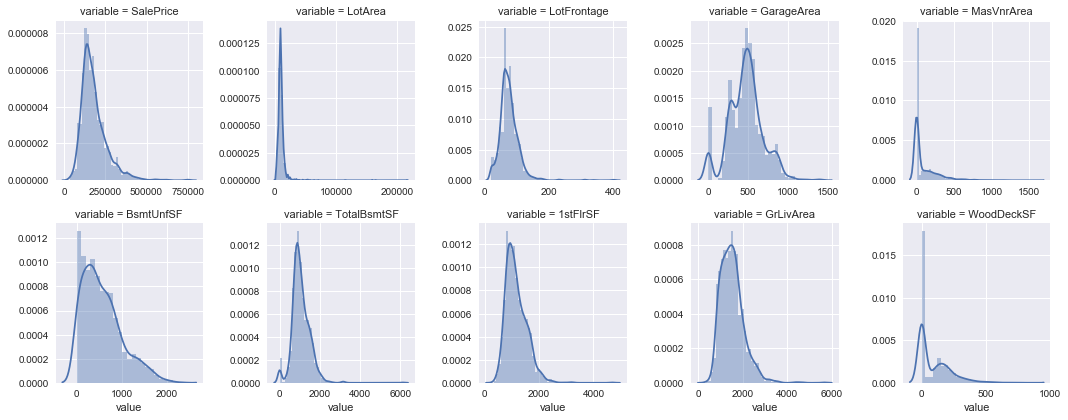

In [14]:
f = pd.melt(train, value_vars=['SalePrice','LotArea','LotFrontage','GarageArea','MasVnrArea','BsmtUnfSF', 'TotalBsmtSF','1stFlrSF','GrLivArea','WoodDeckSF'])
                               
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()


In [15]:
# transform log-normal features to normal features
norm_col = ['SalePrice','LotArea','LotFrontage','GarageArea','MasVnrArea','BsmtUnfSF', 'TotalBsmtSF','1stFlrSF','GrLivArea','WoodDeckSF']
train = normalize_data(train,norm_col)
test = normalize_data(test,norm_col[1:])

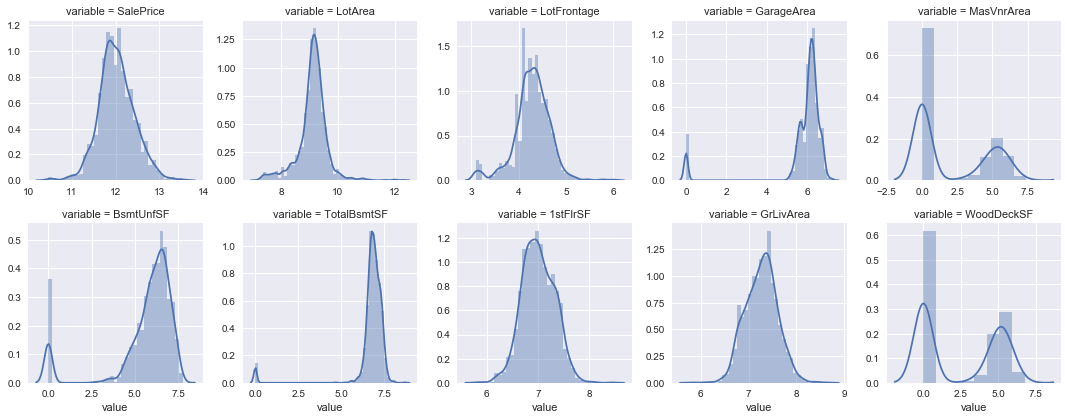

In [16]:
f = pd.melt(train, value_vars=['SalePrice','LotArea','LotFrontage','GarageArea','MasVnrArea','BsmtUnfSF', 'TotalBsmtSF','1stFlrSF','GrLivArea','WoodDeckSF'])
                               
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()


# Correlations

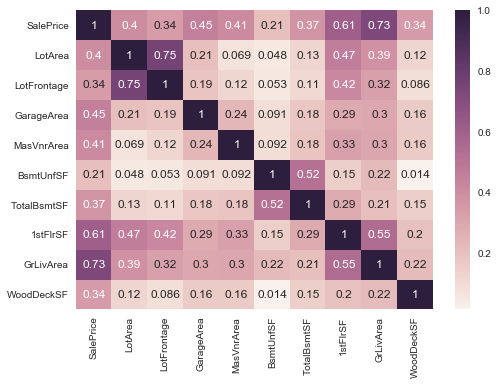

In [17]:
sns.heatmap(train[['SalePrice','LotArea','LotFrontage','GarageArea','MasVnrArea','BsmtUnfSF', 'TotalBsmtSF','1stFlrSF','GrLivArea','WoodDeckSF']].corr(),annot=True)
plt.show()

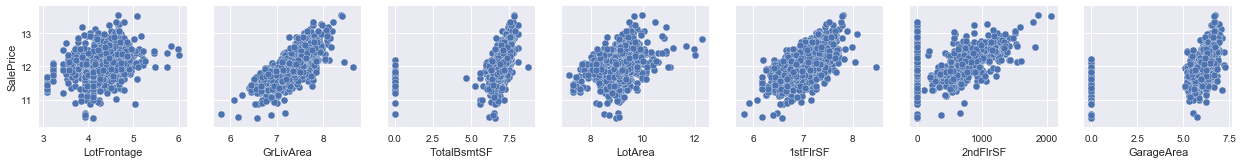

In [18]:
# Remove outliers
train = train[(train['LotArea']<100000) & (train['GrLivArea']<4000)  & (train['GarageArea']<1248)]
sns.pairplot(train,y_vars = ['SalePrice'],x_vars=['LotFrontage','GrLivArea', 'TotalBsmtSF','LotArea','1stFlrSF','2ndFlrSF','GarageArea'], size = 2.5)
plt.show();

In [19]:
train.columns.values


array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

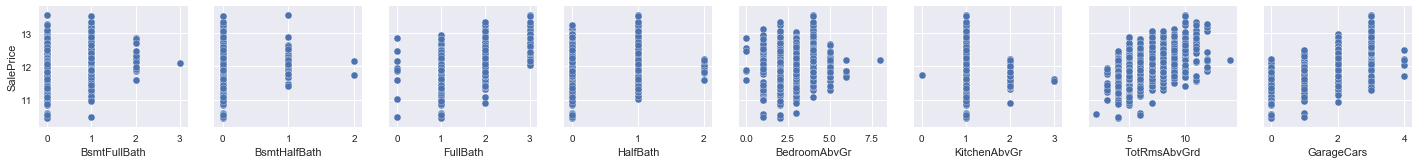

In [20]:
# Remove outliers
sns.pairplot(train,y_vars = ['SalePrice'],x_vars=['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd','GarageCars'], size = 2.5)
plt.show();

In [21]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

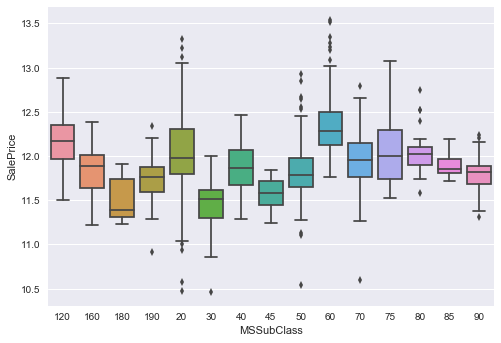

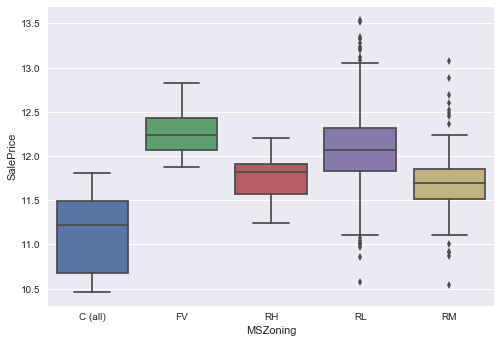

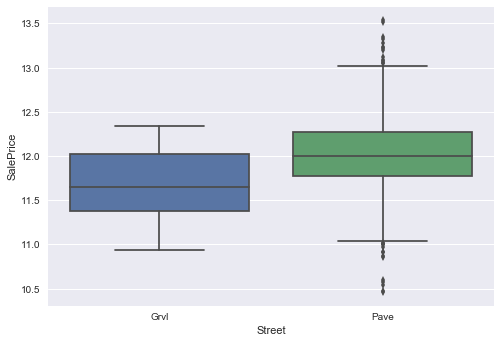

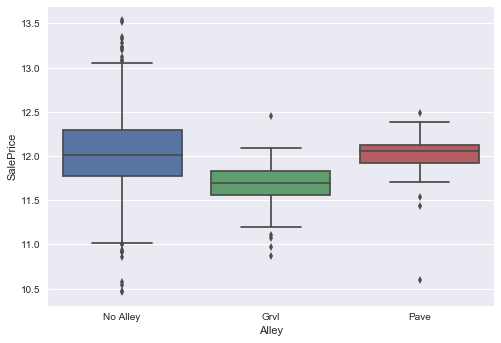

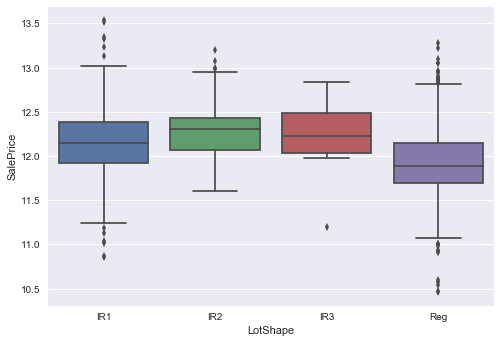

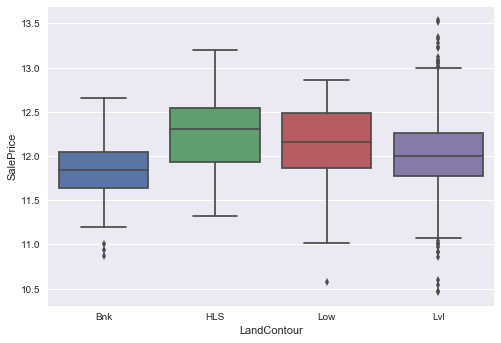

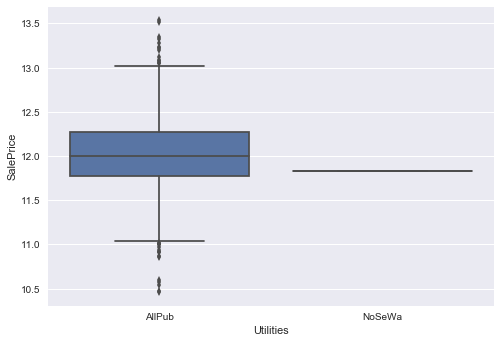

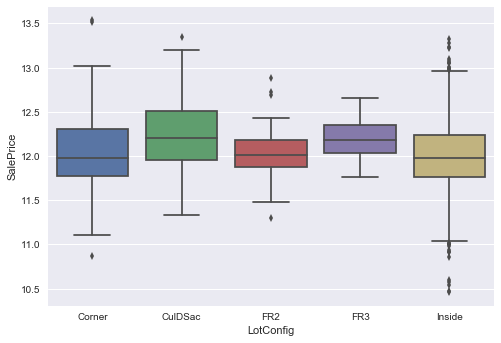

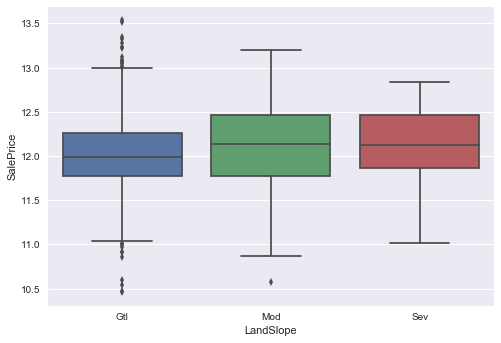

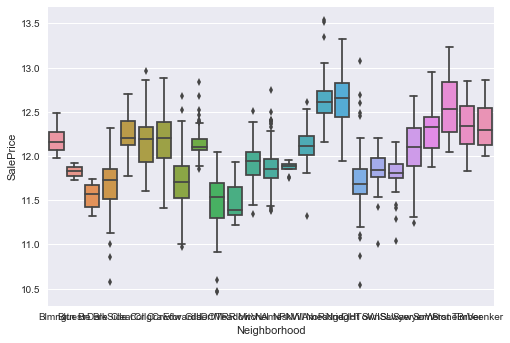

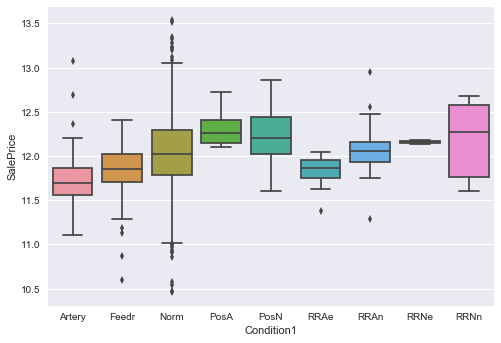

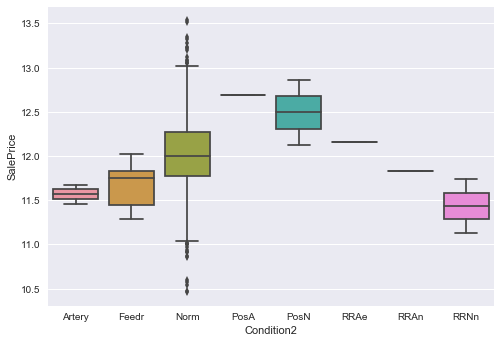

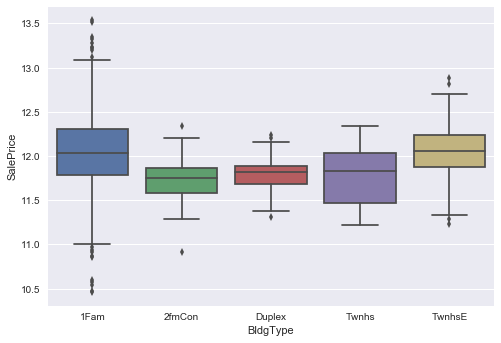

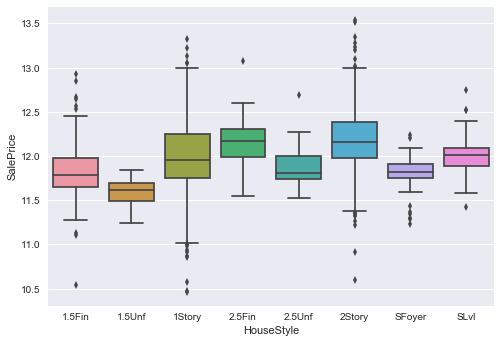

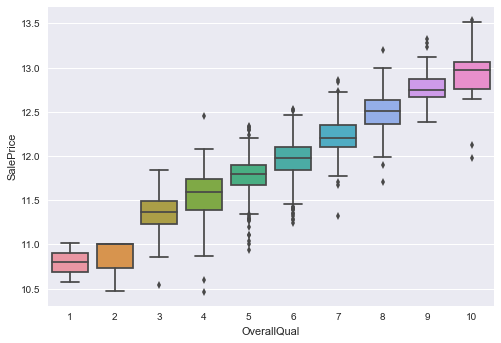

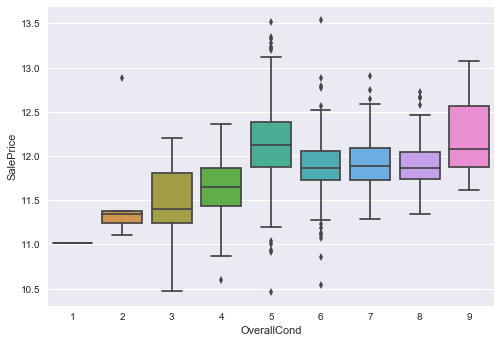

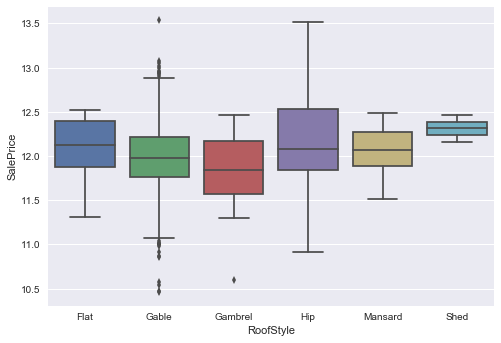

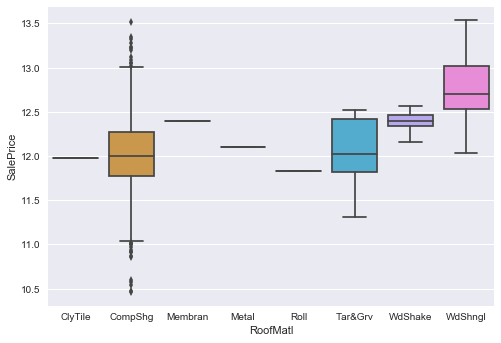

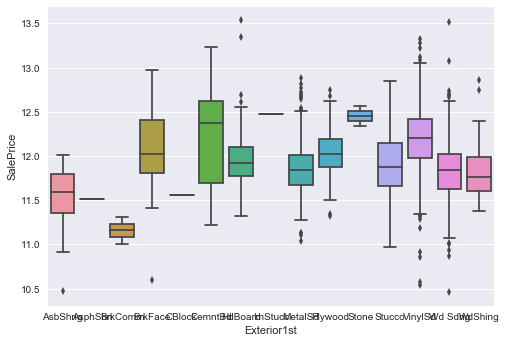

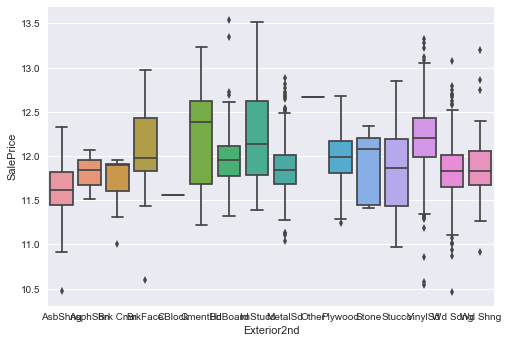

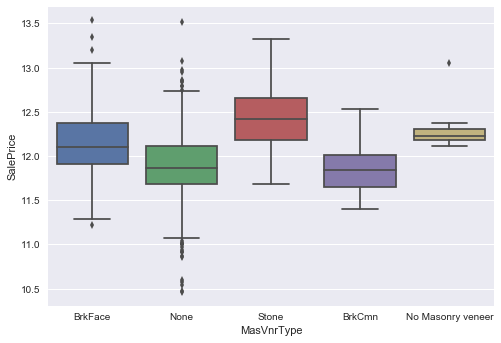

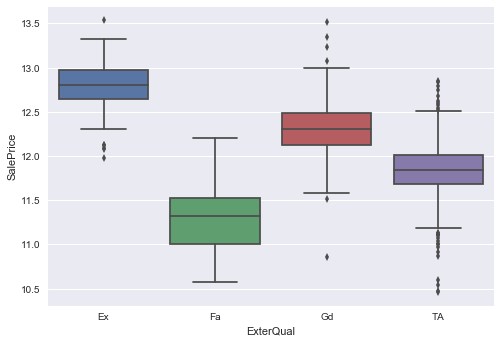

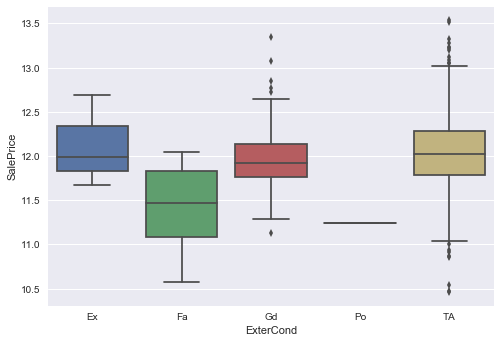

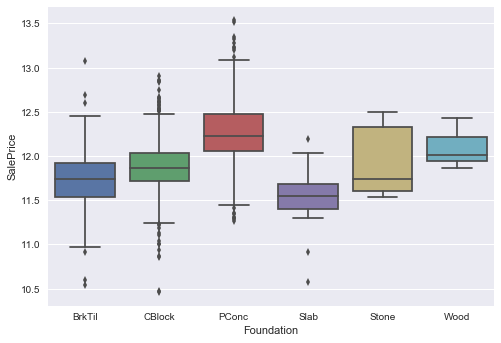

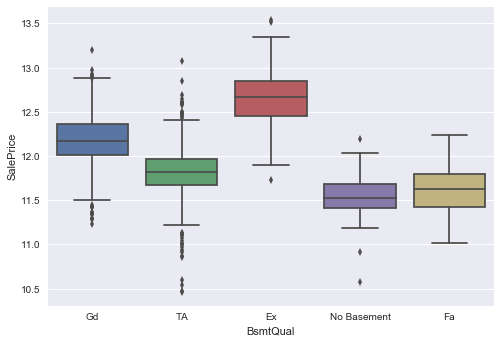

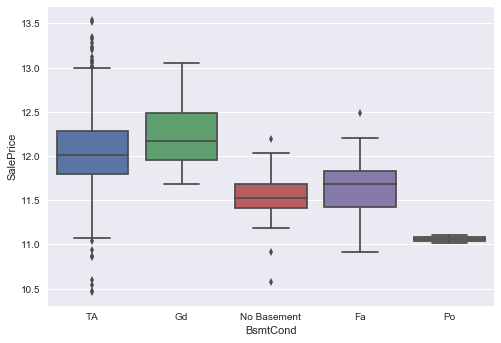

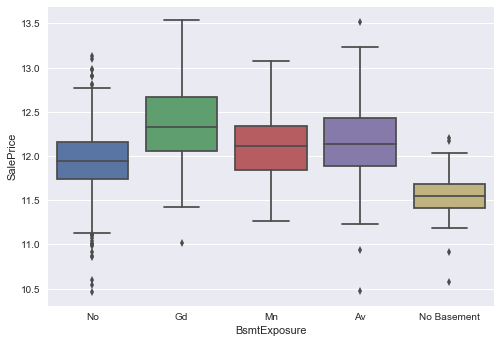

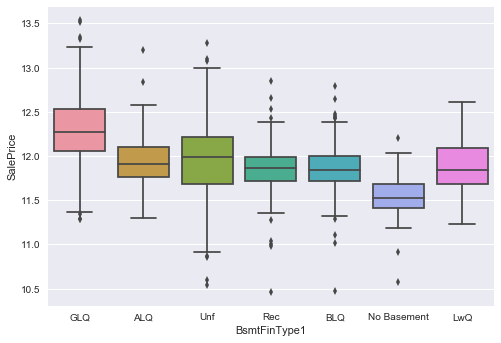

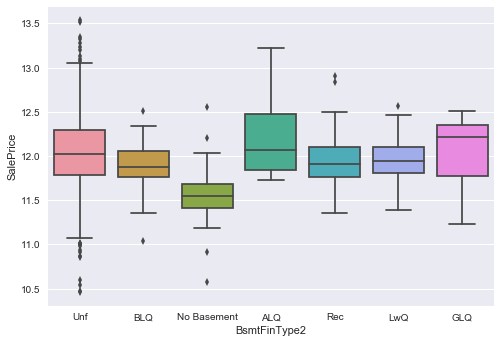

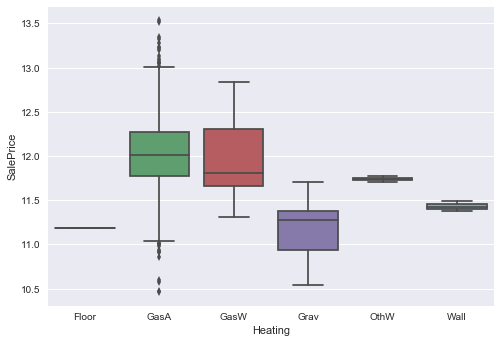

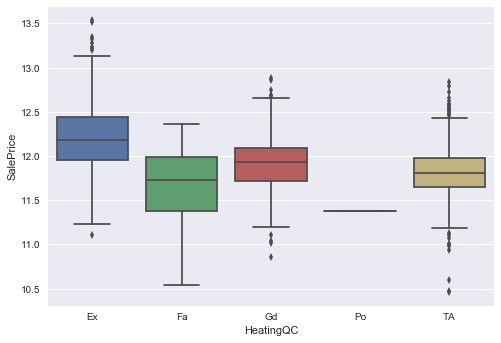

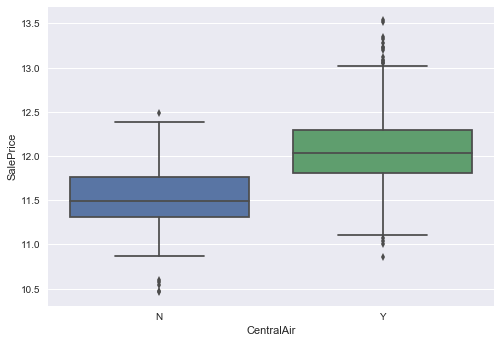

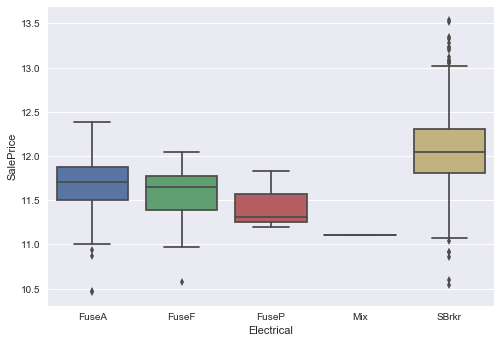

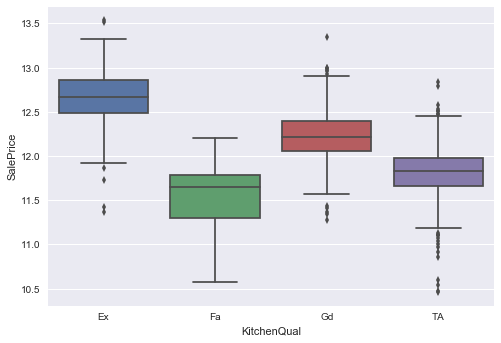

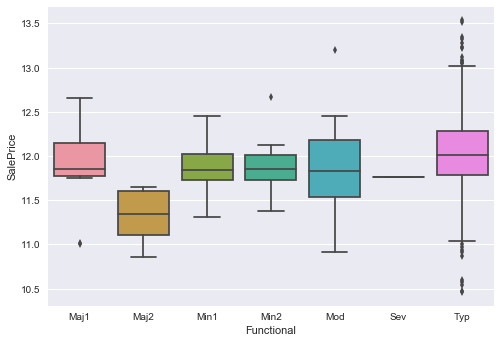

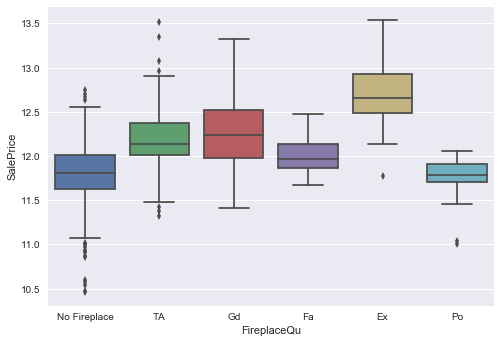

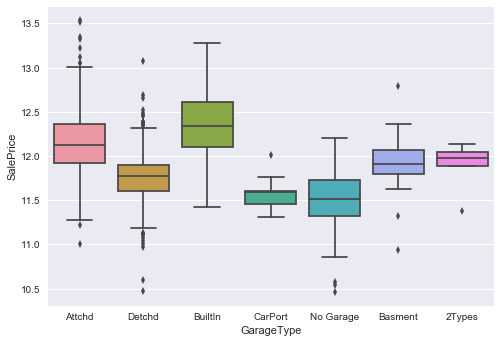

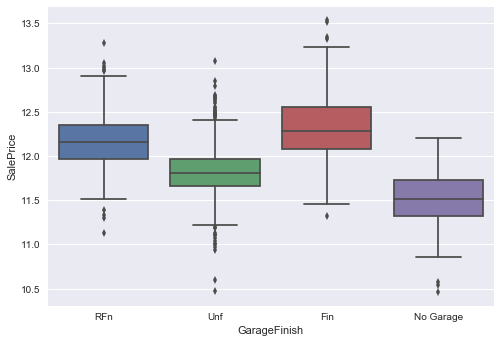

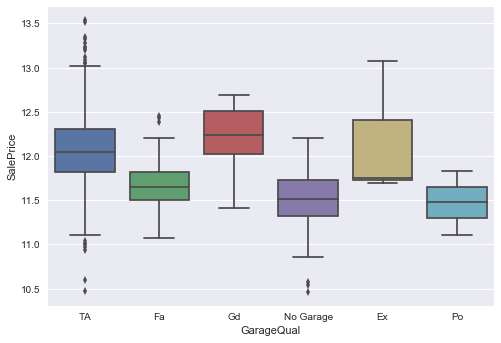

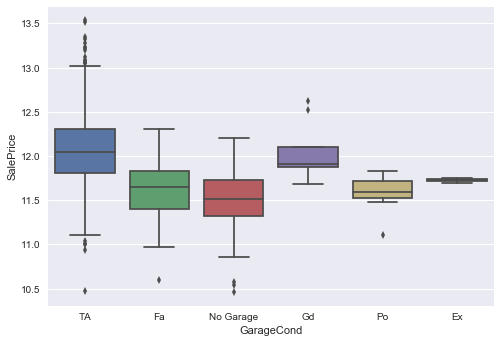

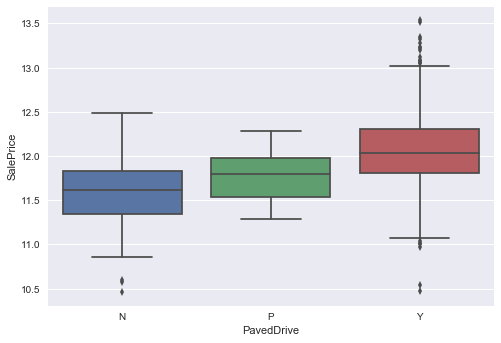

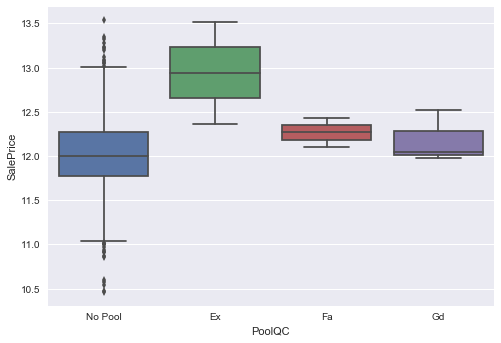

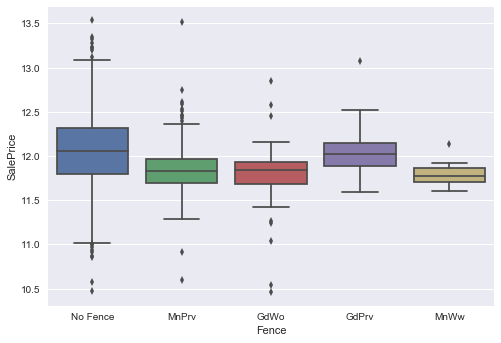

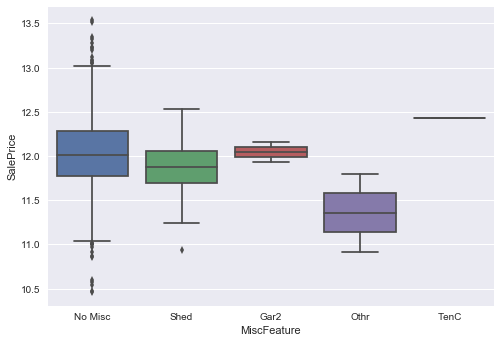

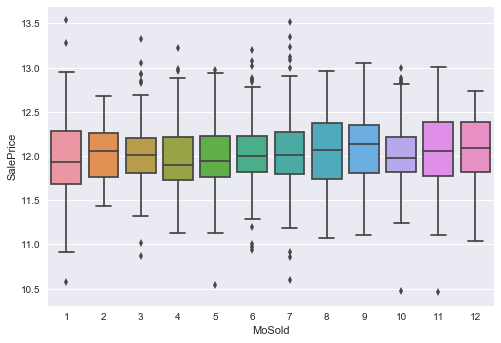

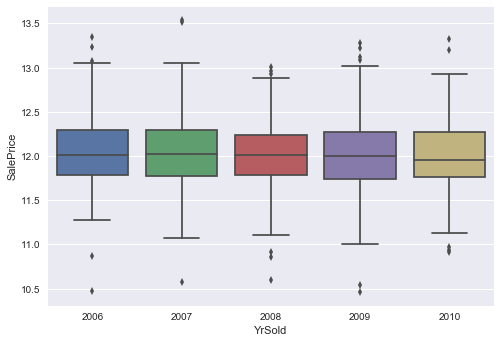

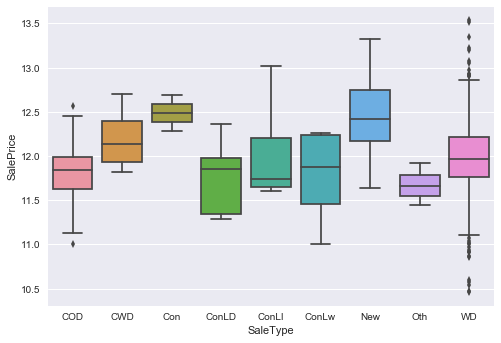

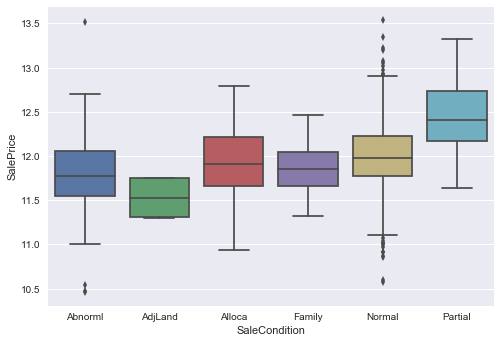

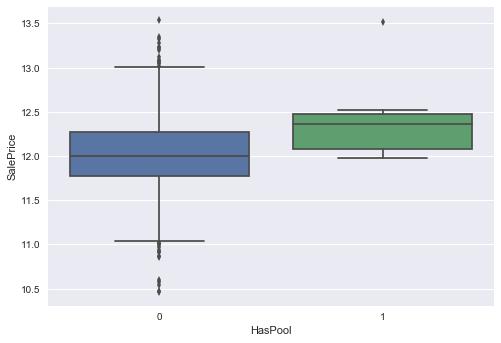

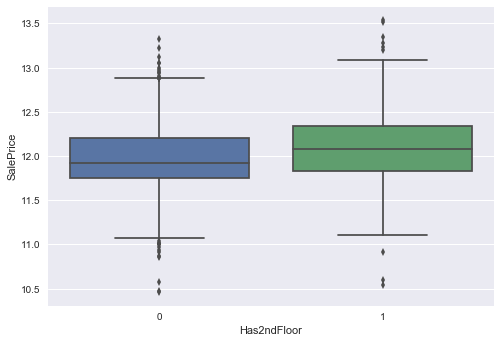

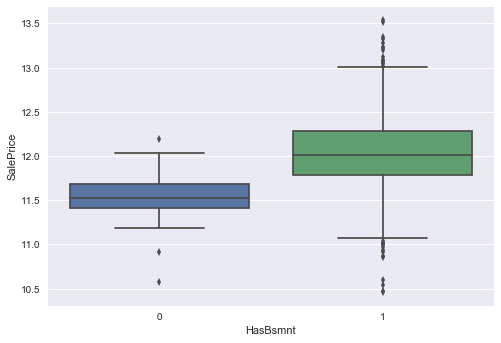

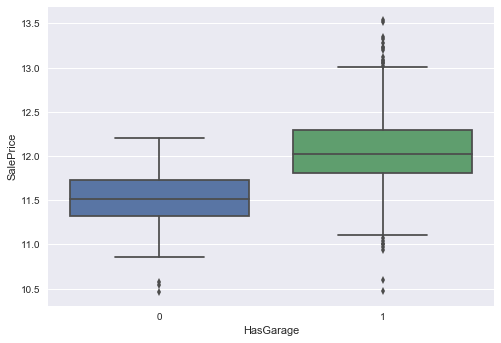

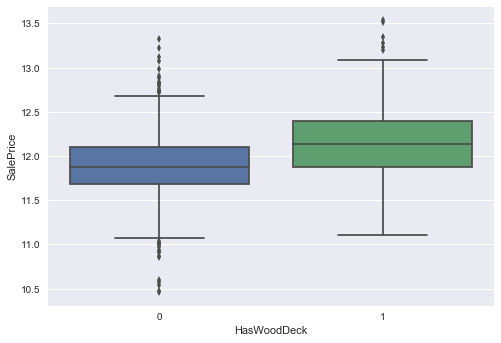

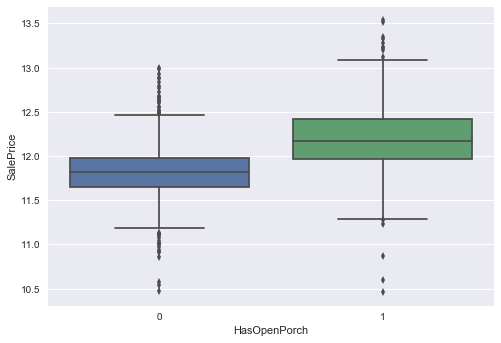

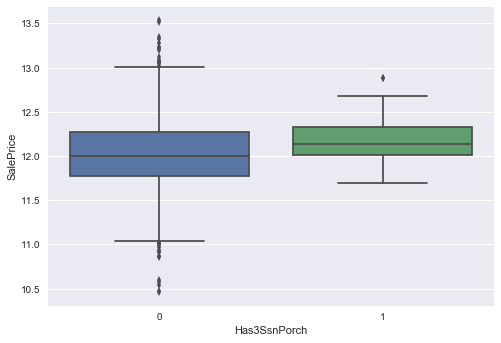

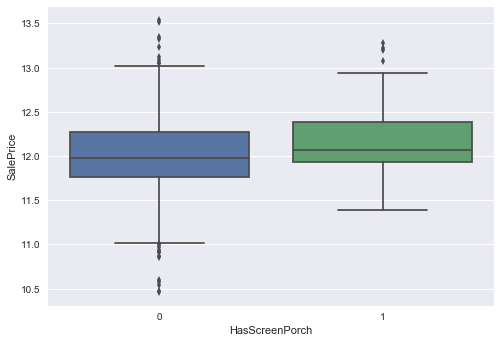

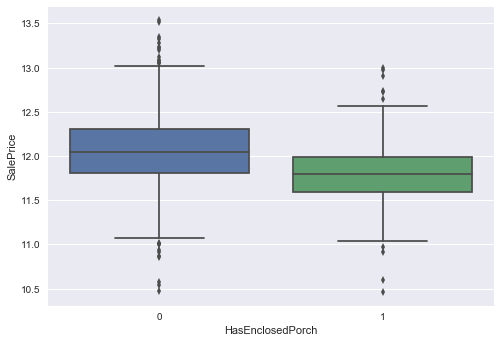

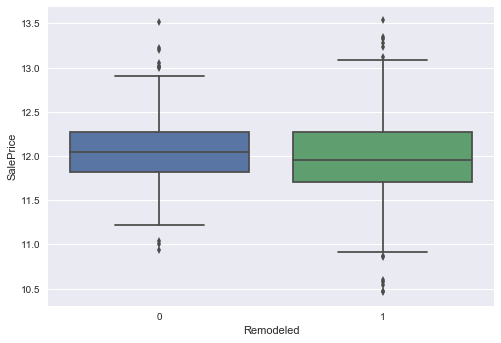

In [22]:
for var in ['MSSubClass', 'MSZoning', 'Street',
            'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig','LandSlope', 'Neighborhood',
            'Condition1', 'Condition2','BldgType','HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
            'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','ExterQual', 'ExterCond', 'Foundation',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2','Heating','HeatingQC',
            'CentralAir', 'Electrical','KitchenQual','Functional','FireplaceQu', 'GarageType',
            'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive','PoolQC','Fence', 'MiscFeature',
            'MoSold', 'YrSold', 'SaleType','SaleCondition','HasPool', 'Has2ndFloor', 'HasBsmnt',
            'HasGarage', 'HasWoodDeck', 'HasOpenPorch', 'Has3SsnPorch','HasScreenPorch', 'HasEnclosedPorch', 'Remodeled']:
    sns.boxplot(x=var,y='SalePrice',data=train)
    plt.show()
    

0    829
1    631
Name: Has2ndFloor, dtype: int64


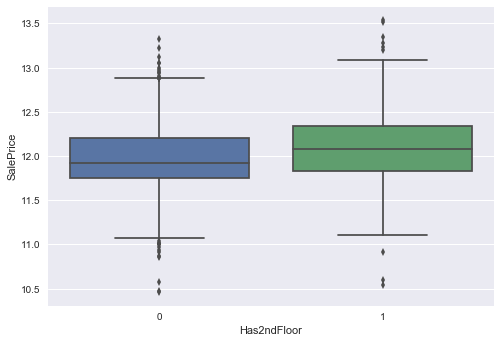

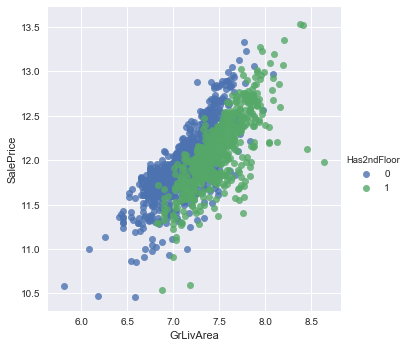

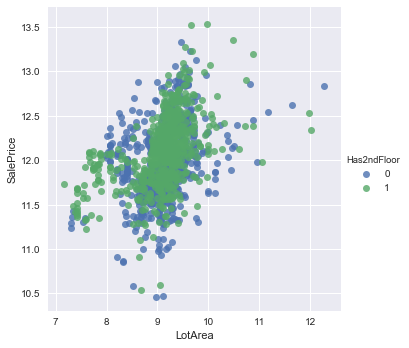

In [23]:
var = 'Has2ndFloor'
print(train[var].value_counts())
sns.boxplot(x=var,y='SalePrice',data=train)
sns.lmplot(x='GrLivArea',y='SalePrice',hue=var,data=train,fit_reg=False)
sns.lmplot(x='LotArea',y='SalePrice',hue=var,data=train,fit_reg=False)
plt.show()

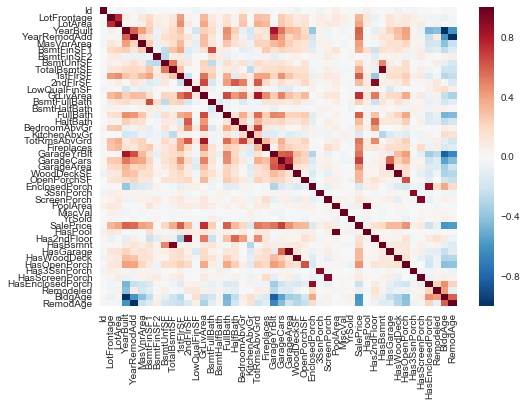

In [24]:
sns.heatmap(train.corr())
plt.show()

# Modeling #
---

In [27]:
drop_col = ['Utilities','Condition2','RoofMatl','MoSold','YrSold','YearBuilt', 'YearRemodAdd','GarageArea','GarageYrBlt','PoolArea','TotalBsmtSF','WoodDeckSF','ScreenPorch','EnclosedPorch','2ndFlrSF','3SsnPorch']
train = train.drop(drop_col, axis = 1)
test = test.drop(drop_col, axis = 1)

In [28]:
# double check missing values
np.max(np.sum(pd.isnull(train)))

0

In [35]:
#np.sum(pd.isnull(test))
test.MSZoning.fillna(test.MSZoning.mode()[0],inplace=True)
test.Exterior1st.fillna(test.Exterior1st.mode()[0],inplace=True)
test.Exterior2nd.fillna(test.Exterior2nd.mode()[0],inplace=True)
test.Functional.fillna(test.Functional.mode()[0],inplace=True)
test.GarageCars.fillna(test.GarageCars.mode()[0],inplace=True)
test.SaleType.fillna(test.SaleType.mode()[0],inplace=True)
test.BsmtFullBath.fillna(test.BsmtFullBath.mode()[0],inplace=True)
test.BsmtHalfBath.fillna(test.BsmtHalfBath.mode()[0],inplace=True)
test.KitchenQual.fillna(test.KitchenQual.mode()[0],inplace=True)
test.BsmtUnfSF.fillna(test.BsmtUnfSF.mean(),inplace=True)
test.BsmtFinSF2.fillna(test.BsmtFinSF2.mean(),inplace=True)
test.BsmtFinSF1.fillna(test.BsmtFinSF1.mean(),inplace=True)


In [36]:
np.max(np.sum(pd.isnull(test)))

0

In [37]:
col = train.columns.tolist()
col = [col[col.index('Id')]]  + [c for c in col if (c != 'SalePrice') and (c != 'Id') ]

In [38]:
train_sale_price = train.pop('SalePrice')
full = pd.concat([train[col],test[col]])
print(full.columns.values)

KeyError: 'SalePrice'

In [39]:
# scale parameters
cont_features = ['LotFrontage', 'LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF',
                 '1stFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd','Fireplaces','GarageCars',
                 'OpenPorchSF','MiscVal']

for feature in cont_features:
    full[feature] = scale(full[feature])

In [40]:
sub = full
sub = pd.get_dummies(sub,drop_first=True)

In [41]:
validation_size = 0.20

seed = 7

In [94]:
train = sub[:train.shape[0]].copy()
test = sub[train.shape[0]:].copy()

In [95]:
col = train.columns.tolist()
col = [col[col.index('Id')]]  + [c for c in col if (c != 'SalePrice') and (c != 'Id') ]
train = train[col]
print(train.columns)

Index(['Id', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=274)


In [96]:
# Test for multicollinearity, iteratively drop features that have high VIF score (>10)
new_col = col.copy()
for c in range(1,len(col)):
    ind = new_col[1:].index(col[c])
    print('VIF of %s: %s'%(col[c],variance_inflation_factor(train[new_col[1:]].values, ind)))    
    if(variance_inflation_factor(train[new_col[1:]].values, ind) > 10):
        new_col.remove(col[c])
        train.drop([col[c]],axis=1,inplace=1)


VIF of LotFrontage: 4.02005174834
VIF of LotArea: 6.34049043483
VIF of MasVnrArea: 27.8882577405
VIF of BsmtFinSF1: 6.01827044787
VIF of BsmtFinSF2: 5.14844237337
VIF of BsmtUnfSF: 3.99390945166
VIF of 1stFlrSF: 24.1671596527
VIF of LowQualFinSF: 3.14658059656
VIF of GrLivArea: 12.1404344211
VIF of BsmtFullBath: 2.97902626554
VIF of BsmtHalfBath: 1.48083161101
VIF of FullBath: 4.0052335943
VIF of HalfBath: 3.15162546872
VIF of BedroomAbvGr: 3.65310318901
VIF of KitchenAbvGr: 5.20516743464
VIF of TotRmsAbvGrd: 5.5118874577
VIF of Fireplaces: 7.68271636067
VIF of GarageCars: 4.13818668274
VIF of OpenPorchSF: 2.39877433598
VIF of MiscVal: 13.3829837765


c:\users\aya\appdata\local\programs\python\python36\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF of HasPool: inf
VIF of Has2ndFloor: 31.158544106
VIF of HasBsmnt: inf
VIF of HasGarage: inf
VIF of HasWoodDeck: 1.60263554692
VIF of HasOpenPorch: 2.7162974543
VIF of Has3SsnPorch: 1.23907110946
VIF of HasScreenPorch: 1.3166404681
VIF of HasEnclosedPorch: 1.77761529842
VIF of Remodeled: 2.17477471106
VIF of BldgAge: 18.0068089235
VIF of RemodAge: 4.06743839925


c:\users\aya\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\linear_model.py:1353: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


VIF of MSSubClass_150: nan
VIF of MSSubClass_160: 10.874833374
VIF of MSSubClass_180: 3.04244414665
VIF of MSSubClass_190: 59.5570621814
VIF of MSSubClass_20: 114.034501537
VIF of MSSubClass_30: 2.77545086138
VIF of MSSubClass_40: 1.8573716896
VIF of MSSubClass_45: 10.6688737232
VIF of MSSubClass_50: 16.9282066872
VIF of MSSubClass_60: 11.3919943227
VIF of MSSubClass_70: 2.83770281399
VIF of MSSubClass_75: 7.01437189938
VIF of MSSubClass_80: 13.8949424229
VIF of MSSubClass_85: 3.87525604126
VIF of MSSubClass_90: inf
VIF of MSZoning_FV: 18.6381055073
VIF of MSZoning_RH: 2.32155664357
VIF of MSZoning_RL: 15.7877809156
VIF of MSZoning_RM: 4.5962931059
VIF of Street_Pave: 1.7225265469
VIF of Alley_No Alley: 2.99237100585
VIF of Alley_Pave: 2.80850319798
VIF of LotShape_IR2: 1.37603498609
VIF of LotShape_IR3: 1.40585892373
VIF of LotShape_Reg: 1.7119393558
VIF of LandContour_HLS: 2.41757270746
VIF of LandContour_Low: 2.63299974492
VIF of LandContour_Lvl: 3.50307724315
VIF of LotConfig_CulDS

In [97]:
Y = train_sale_price
X = train.drop('Id',axis=1).values    


X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)





In [98]:
def adjusted_r2(model,x,y):
    y_hat = model.predict(x)
    RSS = np.sum((y - y_hat)**2)
    TSS = np.sum((y-y.mean())**2)
    n = x.shape[0]
    d = x.shape[1] + 1
    return 1 - RSS/(n - d - 1)/(TSS/(n-1))

## Lasso

In [169]:
kfold = model_selection.KFold(n_splits=5, random_state=seed)
#result_train = rf.fit(X_train,Y_train)
#y_pred = rf.predict(X_train)
lasso_cv = LassoCV(alphas = (0.0000005,0.1,1,100,200,10000),cv=5).fit(X,Y)
print(adjusted_r2(lasso_cv,X, Y))
#print(rf.score(X_train,Y_train))

y_pred_lasso = lasso_cv.predict(X)
sqrt_mse = np.sqrt(np.sum((np.log(y_pred_lasso) - np.log(Y))**2)/len(y_pred_lasso))
print(sqrt_mse)
print(lasso_cv.alpha_)

0.891406201484
0.0102409937247
5e-07


## Ridge

In [160]:
ridge_cv = RidgeCV(alphas = (1,2,3,4,5,6,7,8,9,10,20,100,200,10000),cv=kfold).fit(X,Y)
print(ridge_cv.alpha_)
print(ridge_cv.score(X,Y))
#print(rf.score(X_train,Y_train))

y_pred_ridge = ridge_cv.predict(X)
sqrt_mse = np.sqrt(np.sum((np.log(y_pred_ridge) - np.log(Y))**2)/len(y_pred_ridge))
print(sqrt_mse)

6
0.899758945258
0.0106163637711


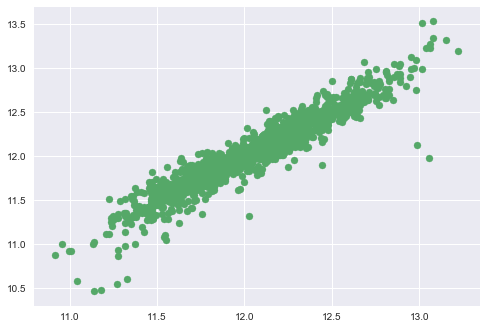

In [162]:
plt.scatter(y_pred_ridge,Y)
plt.show()

## Elastic Net

In [153]:
tuned_parameters = [{'alpha': [0.000001,500],'l1_ratio':[0.000001,500]}]
elastic = GridSearchCV(ElasticNet(alpha=0.001,l1_ratio=1), tuned_parameters, cv=5,scoring='r2').fit(X,Y)
print(elastic.best_score_)
print(elastic.best_estimator_)

c:\users\aya\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\aya\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.862437471165
ElasticNet(alpha=1e-06, copy_X=True, fit_intercept=True, l1_ratio=500,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


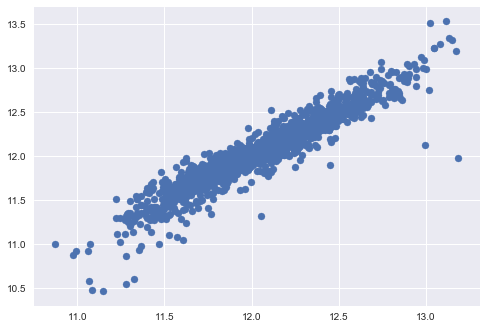

In [163]:
y_pred_elastic = elastic.predict(X)
plt.scatter(y_pred_elastic,Y)
plt.show()

## Random Forest

In [164]:
tuned_parameters = [{'n_estimators': [5,50],'min_samples_split':[2,50],'min_samples_leaf':[2,15]}]
rf = GridSearchCV(RandomForestRegressor(criterion='mse'), tuned_parameters, cv=10,scoring='r2').fit(X,Y)
print(rf.best_score_)
print(rf.best_estimator_)

0.827562742022
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


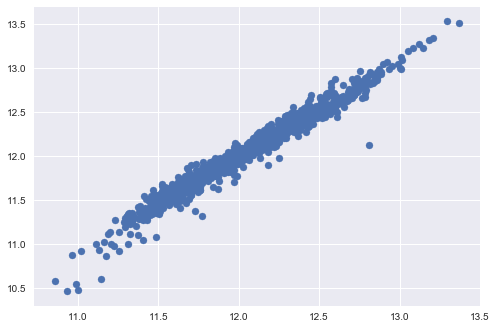

In [165]:
y_pred_rf = rf.predict(X)
plt.scatter(y_pred_rf,Y)
plt.show()

## Closer Look on Error Terms

In [106]:
train = pd.concat([train,pd.DataFrame(y_pred_ridge)],axis=1)
train.columns = [train.columns.tolist()[:-1] + ['y_pred_ridge']]
train.columns

Index(['Id', 'LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       ...
       'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_Oth', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Partial', 'y_pred_ridge'],
      dtype='object', length=207)

In [107]:
train.columns.values

array(['Id', 'LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'OpenPorchSF',
       'HasWoodDeck', 'HasOpenPorch', 'Has3SsnPorch', 'HasScreenPorch',
       'HasEnclosedPorch', 'Remodeled', 'RemodAge', 'MSSubClass_150',
       'MSSubClass_180', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_70',
       'MSSubClass_75', 'MSSubClass_85', 'MSZoning_RH', 'MSZoning_RM',
       'Street_Pave', 'Alley_No Alley', 'Alley_Pave', 'LotShape_IR2',
       'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside',
       'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_Crawfor',
       'Neighborho

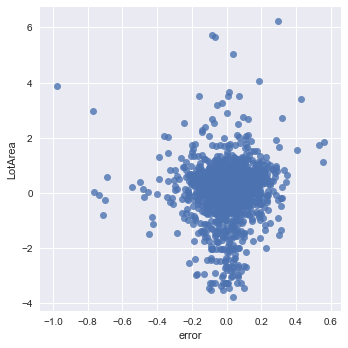

In [114]:
train['SalePrice'] = train_sale_price
train['error'] = train_sale_price - train.y_pred_ridge
sns.lmplot('error','LotArea',data=train,fit_reg=False)
plt.show()

## Predict values for test.csv

In [166]:
test.columns

Index(['Id', 'LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       ...
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_Oth', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Partial'],
      dtype='object', length=206)

In [167]:
test=test[new_col]
X_test = test.iloc[:,1:].values
Y_test = rf.predict(X_test)

pd.DataFrame({'Id': test.Id, 'SalePrice': np.exp(Y_test)}).to_csv('submission_rf.csv', index =False)    


## Compare predictions

In [170]:
results = pd.DataFrame({'lasso':y_pred_lasso,'ridge':y_pred_ridge,'elastic':y_pred_elastic,'random_forest':y_pred_rf})
results.head()

,elastic,lasso,random_forest,ridge
0,12.272939,12.268903,12.257630,12.275307
1,12.099078,12.165779,12.070705,12.150720
2,12.262699,12.256237,12.285421,12.256356
3,12.120101,12.099525,11.939567,12.098751
4,12.685247,12.661547,12.517741,12.659441


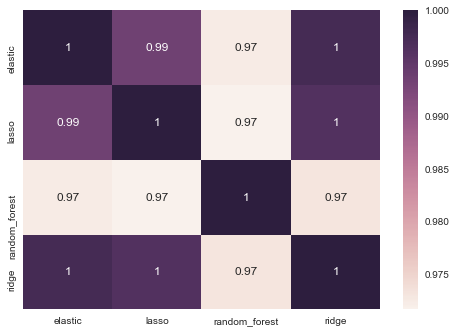

In [171]:
sns.heatmap(results.corr(),annot=True)
plt.show()